<a href="https://colab.research.google.com/github/Hwajun1323/ML/blob/master/result/20frame/cross_validation_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install keras-metrics

In [ ]:
! pip install -q scikit-plot

In [10]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import plot_model

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score , cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from keras.wrappers.scikit_learn import KerasClassifier

import keras_metrics as km

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [11]:
data_dir = "/content/drive/My Drive/dataset/video_data"
#data_dir = "video_data/"
img_height, img_width = 64, 64
seq_len = 20

classes = ["Child's room",  "Museum", "Office", "Restaurant"]
num_classes = len(classes)
print("Number of Class: ", num_classes)

#  Creating frames from videos

def frames_extraction(video_path):
    frames_list = []

    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable
    count = 1

    while count <= seq_len:
        success, image = vidObj.read()
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break

    return frames_list

# Create the actual data from the sequence of images

def create_data(input_dir):
    X = []
    Y = []

    classes_list = os.listdir(input_dir)

    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)

                y = [0] * len(classes)
                y[classes.index(c)] = 1
                Y.append(y)

    X = np.asarray(X)
    Y = np.asarray(Y)
    
    return X, Y

Number of Class:  4


In [12]:
X, Y = create_data(data_dir)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)

Child's room
Restaurant
Office
Museum


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(818, 20, 64, 64, 3)
(205, 20, 64, 64, 3)
(818, 4)
(205, 4)


In [13]:
def create_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), return_sequences=False, data_format="channels_last", input_shape=(seq_len, img_height, img_width, 3)))
    model.add(Dropout(0.3))

    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))

    #model.summary()

    # Various optimizer

    opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = keras.optimizers.SGD(lr=0.001)
    #opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
    #opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
    #opt = keras.optimizers.Adagrad(lr=0.001, epsilon=1e-6)
    #opt = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=None, decay=0.0)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    return model

In [27]:
model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
results = cross_val_score(model, X, Y, cv=kfold)

print('Result of Cross Validation:')
print('cross validation accuracy:',np.round(results, 4))
print('mean accuracy:', np.round(np.mean(results), 4))
print('std :', np.round(np.std  (results), 4))

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_11 (ConvLSTM2D) (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_33 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d_11  (None, 64)                0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)             

In [14]:
from sklearn.model_selection import cross_val_predict

model = KerasClassifier(build_fn=create_model, epochs=80, batch_size=40, verbose=0)
kfold = KFold(n_splits=3, shuffle=True, random_state=None) 
predicted = cross_val_predict(model, X, Y, cv=kfold)
print('Cross validation prediction done!')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_21 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d_7 ( (None, 64)                0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)              

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_8 (ConvLSTM2D)  (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout_24 (Dropout)         (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
global_average_pooling2d_8 ( (None, 64)                0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)              

In [18]:
from sklearn.metrics import precision_recall_fscore_support as score   
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rounded_Y=np.argmax(Y, axis=1)

# Confusion Matrix
cm = confusion_matrix(rounded_Y, predicted) 
print('Confusion matrix: \n')
print(cm)


# Classification report 
targets = ['Class-0', 'Class-1', 'Class-2', 'Class-3']
print('\nClassification report:\n',classification_report(rounded_Y, predicted, target_names=targets))

Confusion matrix: 

[[ 38   0  27 134]
 [ 25   9  20 178]
 [  9   2  55 112]
 [ 29  21  53 311]]

Classification report:
               precision    recall  f1-score   support

     Class-0       0.38      0.19      0.25       199
     Class-1       0.28      0.04      0.07       232
     Class-2       0.35      0.31      0.33       178
     Class-3       0.42      0.75      0.54       414

    accuracy                           0.40      1023
   macro avg       0.36      0.32      0.30      1023
weighted avg       0.37      0.40      0.34      1023



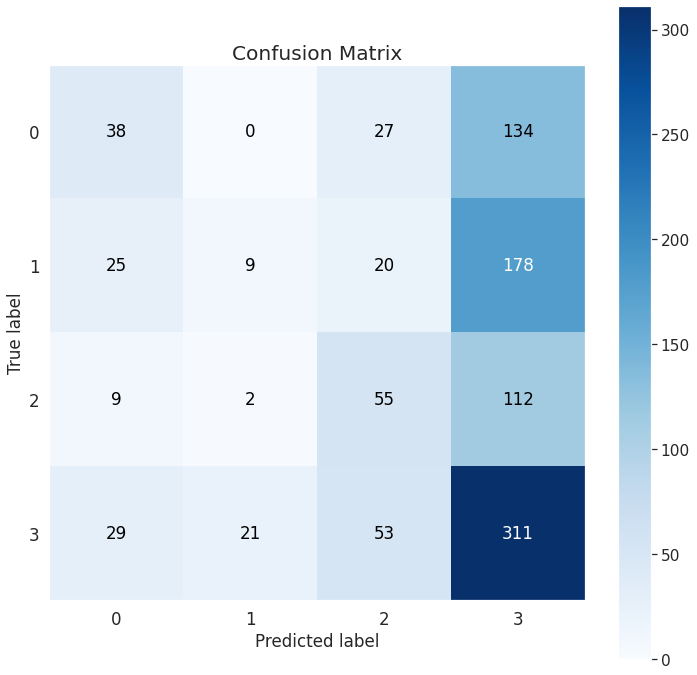

In [25]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(rounded_Y, predicted,figsize=(12,12))

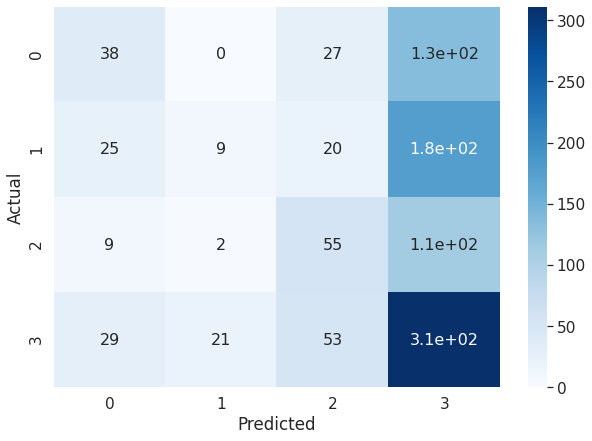

In [22]:
import pandas as pd
import seaborn as sn

df_cm = pd.DataFrame(cm, columns=np.unique(rounded_Y), index = np.unique(rounded_Y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})